# TUV-x: Setting Input Conditions

If you're brand new to TUV-x in MUSICA, start with the TUV-x: Standard Configurations tutorial, then come back here.

The standard conditions that come with the v5.4 and vTS1/TSMLT configurations are great for getting started and comparing rate constant algorithms. Often times however, you'll be interested in photolysis rate constants or dose rates for specific conditions. This tutorial describes how to start with one of the standard TUV-x configurations and modify the atmospheric conditions. We'll use the v5.4 configuration, but these steps could also be followed for the vTS1/TSMLT configuration.

Let's load the dependencies and create a v5.4 TUV-x calculator.

In [1]:
from musica.tuvx import v54
from musica.tuvx import TUVX
import xarray as xr

v54_calculator: TUVX = v54.get_tuvx_calculator()

Before we get into changing conditions, let's look at TUV-x grids, profiles, and radiators.

## Grids

TUV-x uses two grids: altitude and wavelength. Input and output data from TUV-x are primarily on one or both of these grids, either at grid section mid-points or edges. Grid edge and midpoint values for the height and wavelength grids are included in the XArray output of the `TUVX::run()` function, but they can also be accessed via the TUV-x API:

In [2]:
# get the set of grids from TUV-x
v54_grids = v54_calculator.get_grid_map()

# list the available grids
print("Available grids in TUV-x v5.4:")
for grid_name, units in v54_grids:
    print(f" - {grid_name} ({units})")

# print the range and number of sections in the height and wavelength grids
height_grid = v54_grids["height", "km"]
print(f"Height grid: {height_grid.edges.min()} km to {height_grid.edges.max()} km, {len(height_grid)} sections")
wavelength_grid = v54_grids["wavelength", "nm"]
print(f"Wavelength grid: {wavelength_grid.edges.min()} nm to {wavelength_grid.edges.max()} nm, {len(wavelength_grid)} sections")

Available grids in TUV-x v5.4:
 - height (km)
 - wavelength (nm)
Height grid: 0.0 km to 120.0 km, 120 sections
Wavelength grid: 120.0 nm to 735.0 nm, 156 sections


Note that grids returned from the TUV-x grid map are references to the internal TUV-x grid data. Any changes to the grids will impact TUV-x calculations. Although it is possible to change grid values after creation of the TUV-x calculator, it is not recommended and may result in unexpected behavior. We'll see in a future tutorial how to properly define grids prior to creating a TUV-x calculator instance.

## Profiles

Profiles in TUV-x are properties defined on a grid (either height, wavelength, or both). We access them similarly to how grids are accessed:

Available profiles in TUV-x v5.4:
 - air (molecule cm-3)
 - O3 (molecule cm-3)
 - O2 (molecule cm-3)
 - temperature (K)
 - surface albedo (none)
 - extraterrestrial flux (photon cm-2 s-1)


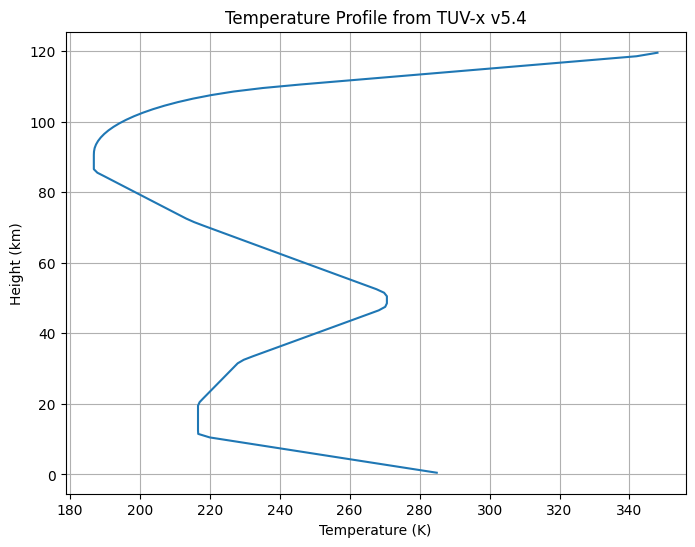

In [3]:
# get the set of profiles from TUV-x
v54_profiles = v54_calculator.get_profile_map()

# list the available profiles
print("Available profiles in TUV-x v5.4:")
for profile_name, units in v54_profiles:
    print(f" - {profile_name} ({units})")

# plot the temperature profile
import matplotlib.pyplot as plt
temperature_profile = v54_profiles["temperature", "K"]
plt.figure(figsize=(8, 6))
plt.plot(temperature_profile.midpoint_values, height_grid.midpoints)
plt.xlabel("Temperature (K)")
plt.ylabel("Height (km)")
plt.title("Temperature Profile from TUV-x v5.4")
plt.grid()
plt.show()

The profiles data are used for solving the radiation field in the column, and can also contribute to photolysis and dose rate calculations (primarily the temperature profile). Temperature, air, and chemical species concentrations are defined on the height grid. Surface albedo and extraterrestrial flux are defined on the wavelength grid.

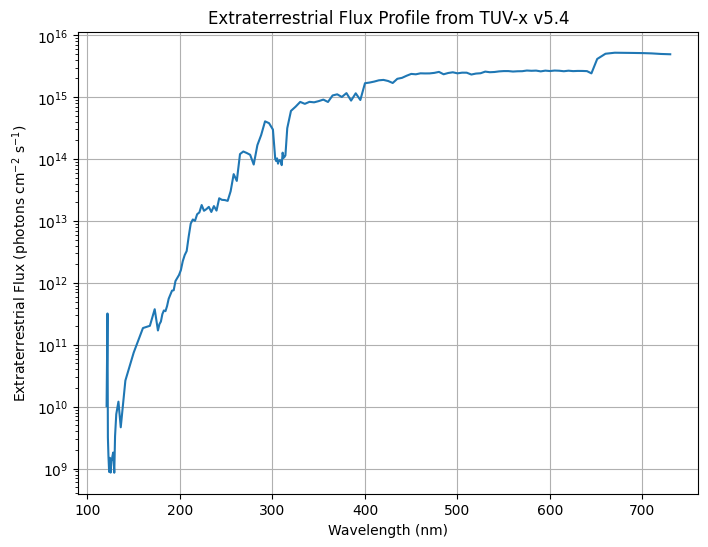

In [4]:
# plot the Extraterrestrial flux profile
extraterrestrial_flux_profile = v54_profiles["extraterrestrial flux", "photon cm-2 s-1"]
plt.figure(figsize=(8, 6))
plt.plot(wavelength_grid.midpoints, extraterrestrial_flux_profile.midpoint_values)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Extraterrestrial Flux (photons cm$^{-2}$ s$^{-1}$)")
plt.title("Extraterrestrial Flux Profile from TUV-x v5.4")
plt.yscale("log")
plt.grid()
plt.show()

Unlike grid data, changing profile data after creation of a TUV-x calculator instance is supported. Later in this tutorial, we'll explore the effects of changing the $\text{O}_3$ concentrations on the calculated photolysis rate constants.

# Radiators

The final data structure used by TUV-x are "radiators". These structures hold the optical properties for atmospheric constituents and are used during the ODE solve of the radiation field. Specifically, they include:
- optical depth (wavelength x height)
- single scattering albedo (wavelength x height)
- asymmetry factor (wavelength x height)

There is a special type of radiator that is for chemical species with associated profiles. These are defined in the TUV-x JSON/YAML configuration file and cannot be modified programmatically. In the v5.4 configuration, there are such radiators defined for air, $\text{O}_3$, and $\text{O}_2$. Any changes to the profiles of air, $\text{O}_2$, or $\text{O}_3$ will update their associated radiator's optical properties automatically. These radiators are not accessible via the TUV-x API.

Additional radiators can be included via the TUV-x API, but you must define the optical properties manually. In the v5.4 configuration, an aerosol radiator is included with predefined optical depth, single scattering albedo, and asymmetry parameter. Later in this section, we'll modify these properties to see their effect on calculated photolysis rate constants.

Radiators can be accessed similarly to grids and profiles:

Available radiators in TUV-x v5.4:
 - aerosol


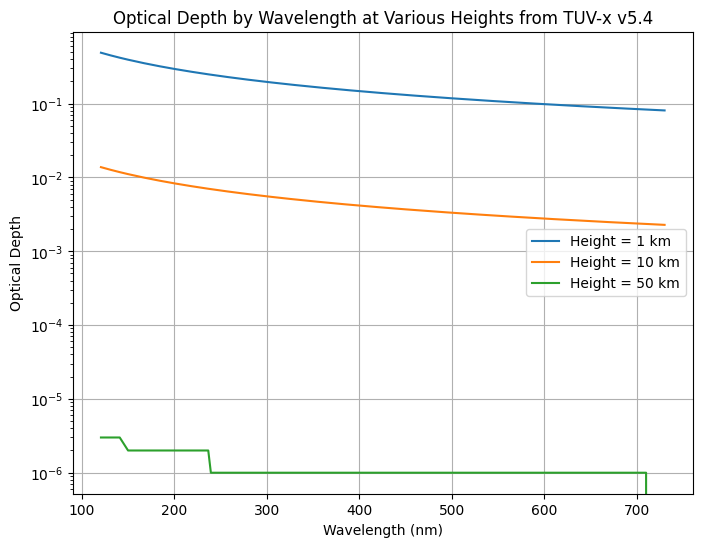

In [5]:
# get the set of radiators from TUV-x
v54_radiators = v54_calculator.get_radiator_map()

# list the available radiators
print("Available radiators in TUV-x v5.4:")
for radiator_name in v54_radiators:
    print(f" - {radiator_name}")

# plot the aerosol optical depth by wavelength at 1, 10, and 50 km
aerosols = v54_radiators["aerosol"]
plt.figure(figsize=(8, 6))
for height in [1, 10, 50]:
    height_index = (abs(height_grid.midpoints - height)).argmin().item()
    plt.plot(wavelength_grid.midpoints, aerosols.optical_depths[:, height_index], label=f"Height = {height} km")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Optical Depth")
plt.title("Optical Depth by Wavelength at Various Heights from TUV-x v5.4")
plt.yscale("log")
plt.legend()
plt.grid()
plt.show()

## Modifying Conditions

Now that we're familiar with the TUV-x datasets, let's compare $\text{O}_3$ photolysis rate constant calculations under different [$\text{O}_3$] and aerosol conditions.

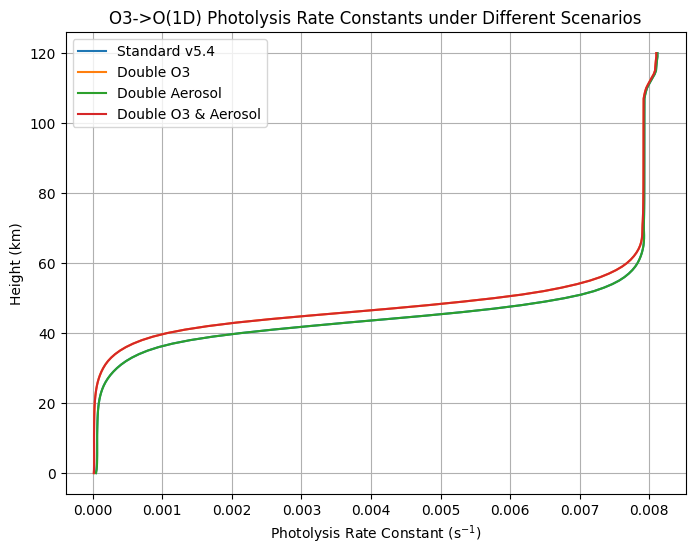

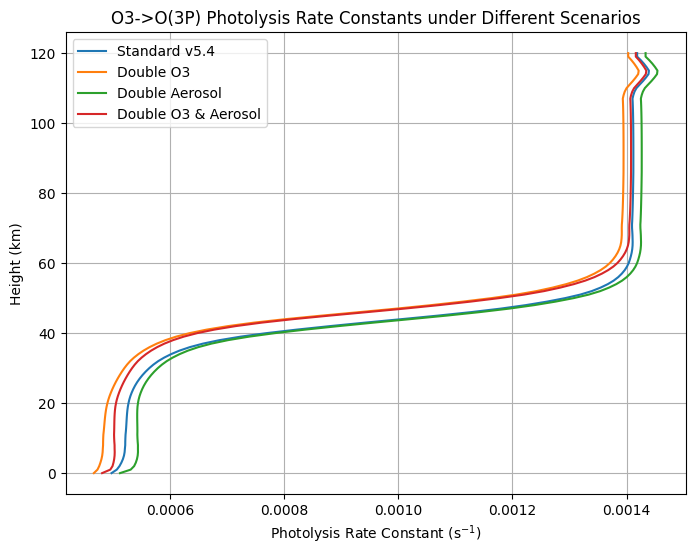

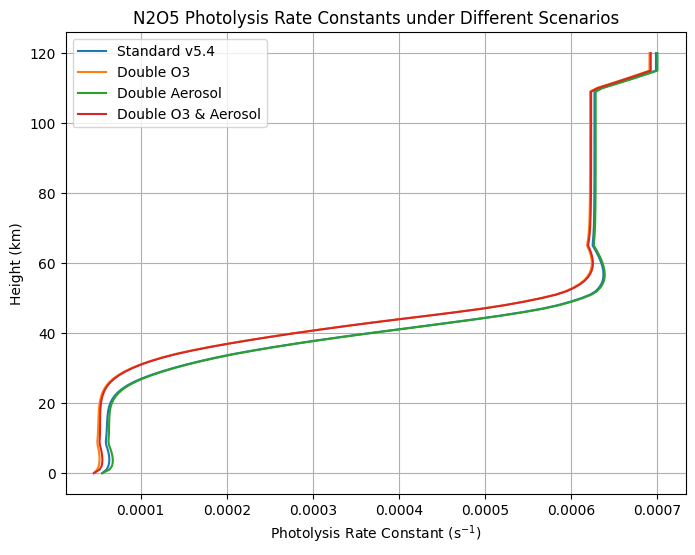

In [6]:
# run the standard v5.4 configuration
v54_results = v54_calculator.run(sza=0.0, earth_sun_distance=1.0)

# double the [O3] in the column and run again
o3_profile = v54_profiles["O3", "molecule cm-3"]
o3_profile.midpoint_values *= 2.0
o3_profile.edge_values *= 2.0
o3_profile.calculate_layer_densities(height_grid) # provide the height grid for layer thicknesses

# rerun the calculation with modified O3 profile
double_o3_results = v54_calculator.run(sza=0.0, earth_sun_distance=1.0)

# double the aerosol optical depths and run again
aerosols.optical_depths *= 2.0

# rerun the calculation with modified aerosol optical depths
double_o3_double_aerosol_results = v54_calculator.run(sza=0.0, earth_sun_distance=1.0)

# return to the original O3 profile and run again
o3_profile.midpoint_values /= 2.0
o3_profile.edge_values /= 2.0
o3_profile.calculate_layer_densities(height_grid) # provide the height grid for layer thicknesses

# rerun the calculation with original O3 profile and doubled aerosol optical depths
double_aerosol_results = v54_calculator.run(sza=0.0, earth_sun_distance=1.0)

# compare the O3 and N2O5 photolysis rate constants among the four scenarios
jo3a_label = "O3+hv->O2+O(1D)"
jo3b_label = "O3+hv->O2+O(3P)"
jn2o5_label = "N2O5+hv->NO2+NO3"
jo3_o1d_v54 = v54_results["photolysis_rate_constants"].sel(reaction=jo3a_label)
jo3_o3p_v54 = v54_results["photolysis_rate_constants"].sel(reaction=jo3b_label)
jn2o5_v54 = v54_results["photolysis_rate_constants"].sel(reaction=jn2o5_label)
height_v54 = v54_grids["height", "km"].edges
jo3_o1d_double_o3 = double_o3_results["photolysis_rate_constants"].sel(reaction=jo3a_label)
jo3_o3p_double_o3 = double_o3_results["photolysis_rate_constants"].sel(reaction=jo3b_label)
jn2o5_double_o3 = double_o3_results["photolysis_rate_constants"].sel(reaction=jn2o5_label)
jo3_o1d_double_aerosol = double_aerosol_results["photolysis_rate_constants"].sel(reaction=jo3a_label)
jo3_o3p_double_aerosol = double_aerosol_results["photolysis_rate_constants"].sel(reaction=jo3b_label)
jn2o5_double_aerosol = double_aerosol_results["photolysis_rate_constants"].sel(reaction=jn2o5_label)
jo3_o1d_double_o3_double_aerosol = double_o3_double_aerosol_results["photolysis_rate_constants"].sel(reaction=jo3a_label)
jo3_o3p_double_o3_double_aerosol = double_o3_double_aerosol_results["photolysis_rate_constants"].sel(reaction=jo3b_label)
jn2o5_double_o3_double_aerosol = double_o3_double_aerosol_results["photolysis_rate_constants"].sel(reaction=jn2o5_label)

# plot the O3->O(1D) photolysis rate constants
plt.figure(figsize=(8, 6))
plt.plot(jo3_o1d_v54, height_v54, label="Standard v5.4")
plt.plot(jo3_o1d_double_o3, height_v54, label="Double O3")
plt.plot(jo3_o1d_double_aerosol, height_v54, label="Double Aerosol")
plt.plot(jo3_o1d_double_o3_double_aerosol, height_v54, label="Double O3 & Aerosol")
plt.xlabel("Photolysis Rate Constant (s$^{-1}$)")
plt.ylabel("Height (km)")
plt.title("O3->O(1D) Photolysis Rate Constants under Different Scenarios")
plt.legend()
plt.grid()
plt.show()

# plot the O3->O(3P) photolysis rate constants
plt.figure(figsize=(8, 6))
plt.plot(jo3_o3p_v54, height_v54, label="Standard v5.4")
plt.plot(jo3_o3p_double_o3, height_v54, label="Double O3")
plt.plot(jo3_o3p_double_aerosol, height_v54, label="Double Aerosol")
plt.plot(jo3_o3p_double_o3_double_aerosol, height_v54, label="Double O3 & Aerosol")
plt.xlabel("Photolysis Rate Constant (s$^{-1}$)")
plt.ylabel("Height (km)")
plt.title("O3->O(3P) Photolysis Rate Constants under Different Scenarios")
plt.legend()
plt.grid()
plt.show()

# plot the N2O5 photolysis rate constants
plt.figure(figsize=(8, 6))
plt.plot(jn2o5_v54, height_v54, label="Standard v5.4")
plt.plot(jn2o5_double_o3, height_v54, label="Double O3")
plt.plot(jn2o5_double_aerosol, height_v54, label="Double Aerosol")
plt.plot(jn2o5_double_o3_double_aerosol, height_v54, label="Double O3 & Aerosol")
plt.xlabel("Photolysis Rate Constant (s$^{-1}$)")
plt.ylabel("Height (km)")
plt.title("N2O5 Photolysis Rate Constants under Different Scenarios")
plt.legend()
plt.grid()
plt.show()